In [1]:

import numpy as np

# Load npz
data = np.load("../data/digits_8features_data.npz")

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

print(f"Training X shape: {X_train.shape}, y shape: {y_train.shape}")
print(f"Validation X shape: {X_val.shape}, y shape: {y_val.shape}")
print(f"Testing X shape: {X_test.shape}, y shape: {y_test.shape}")

Training X shape: (300, 8), y shape: (300,)
Validation X shape: (100, 8), y shape: (100,)
Testing X shape: (100, 8), y shape: (100,)


In [ ]:
# Load all depths and find the best model (lowest loss) for each depth
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

import pickle
import numpy as np

results_dir = '../results_tqfm_digits'

# Define depths to analyze
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
best_models = {}

for depth in depths:
    # Filter TQFM pickle files for this depth
    tqfm_files = [f for f in os.listdir(results_dir) if f.endswith('.pkl') and f'depth{depth}' in f]
    
    if not tqfm_files:
        print(f"No files found for depth {depth}")
        continue
    
    # Load all models for this depth and find best by loss
    models = []
    for tqfm_file in sorted(tqfm_files):
        with open(os.path.join(results_dir, tqfm_file), 'rb') as f:
            tqfm = pickle.load(f)
            final_loss = tqfm.loss_history[-1] if len(tqfm.loss_history) > 0 else float('inf')
            models.append((tqfm, tqfm_file, final_loss))
    
    # Find the model with lowest final loss
    best_model = min(models, key=lambda x: x[2])
    best_tqfm, best_tqfm_file, best_loss = best_model
    
    # Load corresponding kernel file
    # Convert tqfm filename to kernel filename: tqfm_iris_... -> kernels_iris_...
    kernel_file = best_tqfm_file.replace('tqfm_', 'kernels_').replace('.pkl', '.npz')
    kernel_path = os.path.join(results_dir, kernel_file)
    
    if os.path.exists(kernel_path):
        kernel_data = np.load(kernel_path)
        best_models[depth] = {
            'tqfm': best_tqfm,
            'tqfm_file': best_tqfm_file,
            'kernel_data': kernel_data,
            'kernel_file': kernel_file,
            'loss': best_loss
        }
        print(f"Depth {depth}: Loaded {len(models)} models")
        print(f"  Best loss = {best_loss:.6f}")
        print(f"  TQFM file: {best_tqfm_file}")
        print(f"  Kernel file: {kernel_file}")
    else:
        print(f"Warning: Kernel file not found for {best_tqfm_file}")

print(f"\nTotal depths analyzed: {len(best_models)}")

Depth 1: Loaded 5 models
  Best loss = 0.407403
  TQFM file: tqfm_iris_depth1_ansatzRealAmplitudes_iter100000_run1.pkl
  Kernel file: kernels_iris_depth1_ansatzRealAmplitudes_iter100000_run1.npz
Depth 2: Loaded 5 models
  Best loss = 0.341275
  TQFM file: tqfm_iris_depth2_ansatzRealAmplitudes_iter100000_run1.pkl
  Kernel file: kernels_iris_depth2_ansatzRealAmplitudes_iter100000_run1.npz
Depth 3: Loaded 5 models
  Best loss = 0.334347
  TQFM file: tqfm_iris_depth3_ansatzRealAmplitudes_iter100000_run1.pkl
  Kernel file: kernels_iris_depth3_ansatzRealAmplitudes_iter100000_run1.npz
Depth 4: Loaded 5 models
  Best loss = 0.246511
  TQFM file: tqfm_iris_depth4_ansatzRealAmplitudes_iter100000_run1.pkl
  Kernel file: kernels_iris_depth4_ansatzRealAmplitudes_iter100000_run1.npz
Depth 5: Loaded 5 models
  Best loss = 0.187020
  TQFM file: tqfm_iris_depth5_ansatzRealAmplitudes_iter100000_run1.pkl
  Kernel file: kernels_iris_depth5_ansatzRealAmplitudes_iter100000_run1.npz

Total depths analyzed: 5

## Analysis Strategy

For each depth (1-5):
1. Load all 5 TQFM models (different initial theta values)
2. Select the model with the **lowest final loss** 
3. Load the **corresponding pre-computed kernel matrices** from `.npz` files
4. Calculate accuracies using the pre-computed kernels (no recalculation needed)
5. Compare performance across depths

In [30]:
# Calculate accuracy for each best model using pre-computed kernels
from src.utils import calculate_accuracy, class_similarity

accuracy_results = {}

for depth, model_info in best_models.items():
    kernel_data = model_info['kernel_data']
    
    # Load pre-computed kernel matrices (using correct key names)
    K_train = kernel_data['kernel_train_after']  # Trained kernel for training data
    K_val = kernel_data['kernel_val']            # Validation kernel
    K_test = kernel_data['kernel_test']          # Test kernel
    
    # Calculate accuracies using src.utils (includes C parameter optimization)
    val_acc, test_acc, best_c = calculate_accuracy(K_train, K_val, K_test, y_train, y_val, y_test)
    
	
    # Calculate class similarity metrics
    within_sims, avg_within, avg_between, sep_ratio = class_similarity(K_train, y_train)
    
    # Get final loss from TQFM
    loss = model_info['loss']
    
    accuracy_results[depth] = {
        'val_acc': val_acc,
        'test_acc': test_acc,
        'loss': loss,
        'avg_within': avg_within,
        'avg_between': avg_between,
        'sep_ratio': sep_ratio,
        'tqfm_file': model_info['tqfm_file'],
        'kernel_file': model_info['kernel_file']
    }
    
    print(f"Depth {depth}:")
    print(f"  Loss: {loss:.6f}")
    print(f"  Best C: {best_c:.3f}")
    print(f"  Val Acc: {val_acc:.4f}")
    print(f"  Test Acc: {test_acc:.4f}")
    print(f"  Separability Ratio: {sep_ratio:.4f}")
    print()

Depth 1:
  Loss: 0.407403
  Best C: 1.501
  Val Acc: 0.9667
  Test Acc: 0.9333
  Separability Ratio: 1.6841

Depth 2:
  Loss: 0.341275
  Best C: 72.501
  Val Acc: 1.0000
  Test Acc: 0.9000
  Separability Ratio: 2.5926

Depth 2:
  Loss: 0.341275
  Best C: 72.501
  Val Acc: 1.0000
  Test Acc: 0.9000
  Separability Ratio: 2.5926

Depth 3:
  Loss: 0.334347
  Best C: 98.001
  Val Acc: 1.0000
  Test Acc: 0.9333
  Separability Ratio: 2.7357

Depth 3:
  Loss: 0.334347
  Best C: 98.001
  Val Acc: 1.0000
  Test Acc: 0.9333
  Separability Ratio: 2.7357

Depth 4:
  Loss: 0.246511
  Best C: 61.501
  Val Acc: 1.0000
  Test Acc: 0.9000
  Separability Ratio: 3.5580

Depth 4:
  Loss: 0.246511
  Best C: 61.501
  Val Acc: 1.0000
  Test Acc: 0.9000
  Separability Ratio: 3.5580

Depth 5:
  Loss: 0.187020
  Best C: 0.501
  Val Acc: 0.9667
  Test Acc: 0.9333
  Separability Ratio: 4.2883

Depth 5:
  Loss: 0.187020
  Best C: 0.501
  Val Acc: 0.9667
  Test Acc: 0.9333
  Separability Ratio: 4.2883



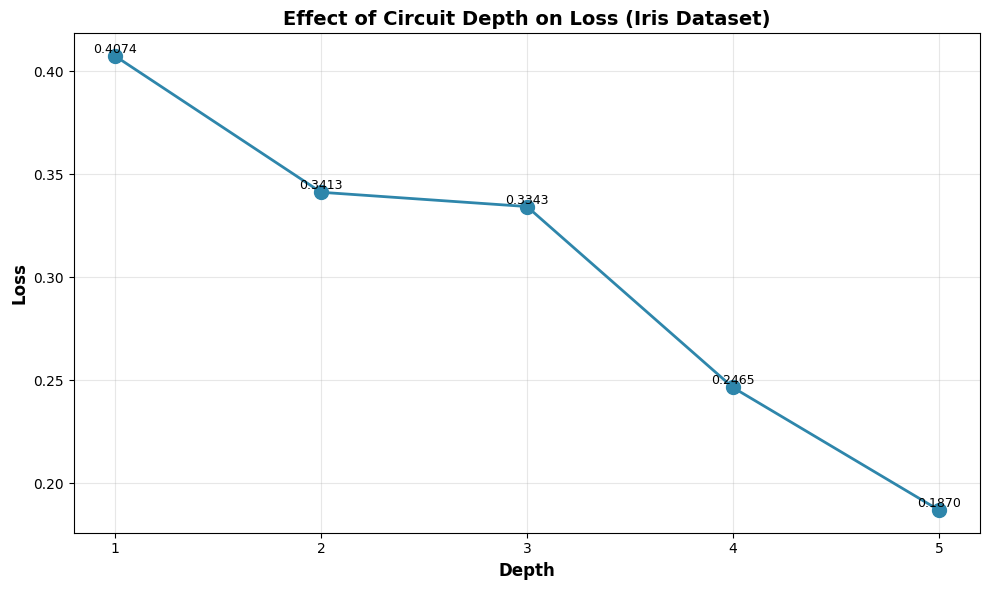

Loss Summary:
Depth 1: 0.407403
Depth 2: 0.341275
Depth 3: 0.334347
Depth 4: 0.246511
Depth 5: 0.187020


In [33]:
# Visualize Loss vs Depth
import matplotlib.pyplot as plt
import numpy as np

depths_list = sorted(accuracy_results.keys())
losses = [accuracy_results[d]['loss'] for d in depths_list]

plt.figure(figsize=(10, 6))
plt.plot(depths_list, losses, 'o-', linewidth=2, markersize=10, color='#2E86AB')
plt.xlabel('Depth', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Effect of Circuit Depth on Loss (Iris Dataset)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(depths_list)

# Add value labels on each point
for d, loss in zip(depths_list, losses):
    plt.text(d, loss, f'{loss:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("Loss Summary:")
for d in depths_list:
    print(f"Depth {d}: {accuracy_results[d]['loss']:.6f}")

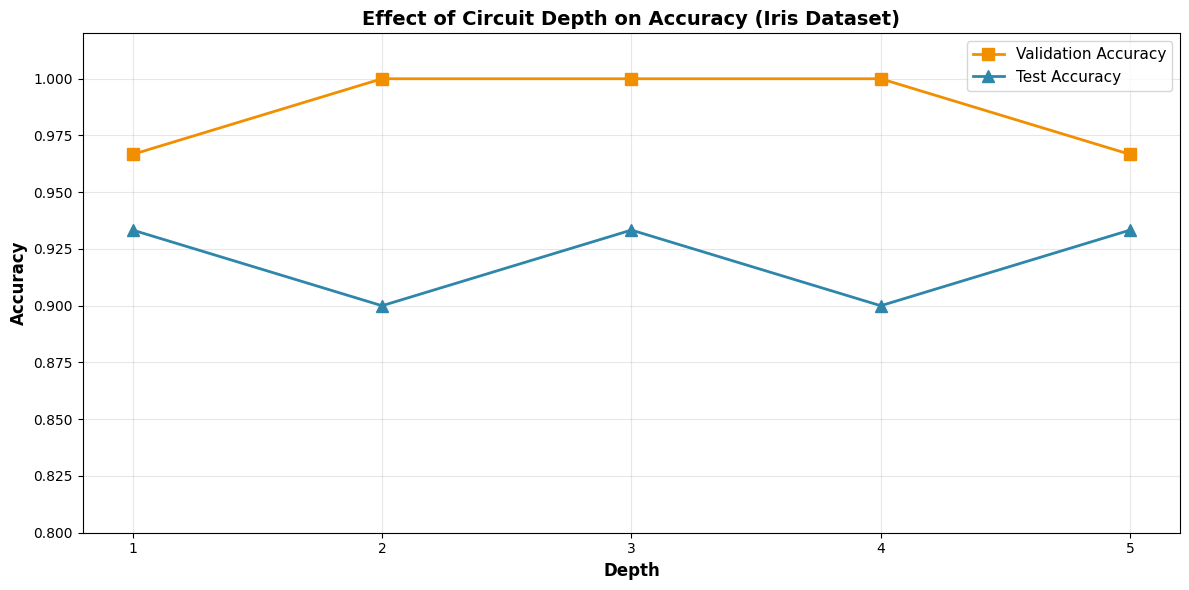


Accuracy Summary:
Depth    Validation   Test      
---------------------------------------------
1        0.9667       0.9333    
2        1.0000       0.9000    
3        1.0000       0.9333    
4        1.0000       0.9000    
5        0.9667       0.9333    


In [35]:
# Visualize Accuracy vs Depth
depths_list = sorted(accuracy_results.keys())
val_accs = [accuracy_results[d]['val_acc'] for d in depths_list]
test_accs = [accuracy_results[d]['test_acc'] for d in depths_list]

plt.figure(figsize=(12, 6))

plt.plot(depths_list, val_accs, 's-', linewidth=2, markersize=8, label='Validation Accuracy', color='#F18F01')
plt.plot(depths_list, test_accs, '^-', linewidth=2, markersize=8, label='Test Accuracy', color='#2E86AB')

plt.xlabel('Depth', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Effect of Circuit Depth on Accuracy (Iris Dataset)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(depths_list)
plt.ylim([0.8, 1.02])

plt.tight_layout()
plt.show()

print("\nAccuracy Summary:")
print(f"{'Depth':<8} {'Validation':<12} {'Test':<10}")
print("-" * 45)
for d in depths_list:
    print(f"{d:<8} {val_accs[depths_list.index(d)]:<12.4f} {test_accs[depths_list.index(d)]:<10.4f}")

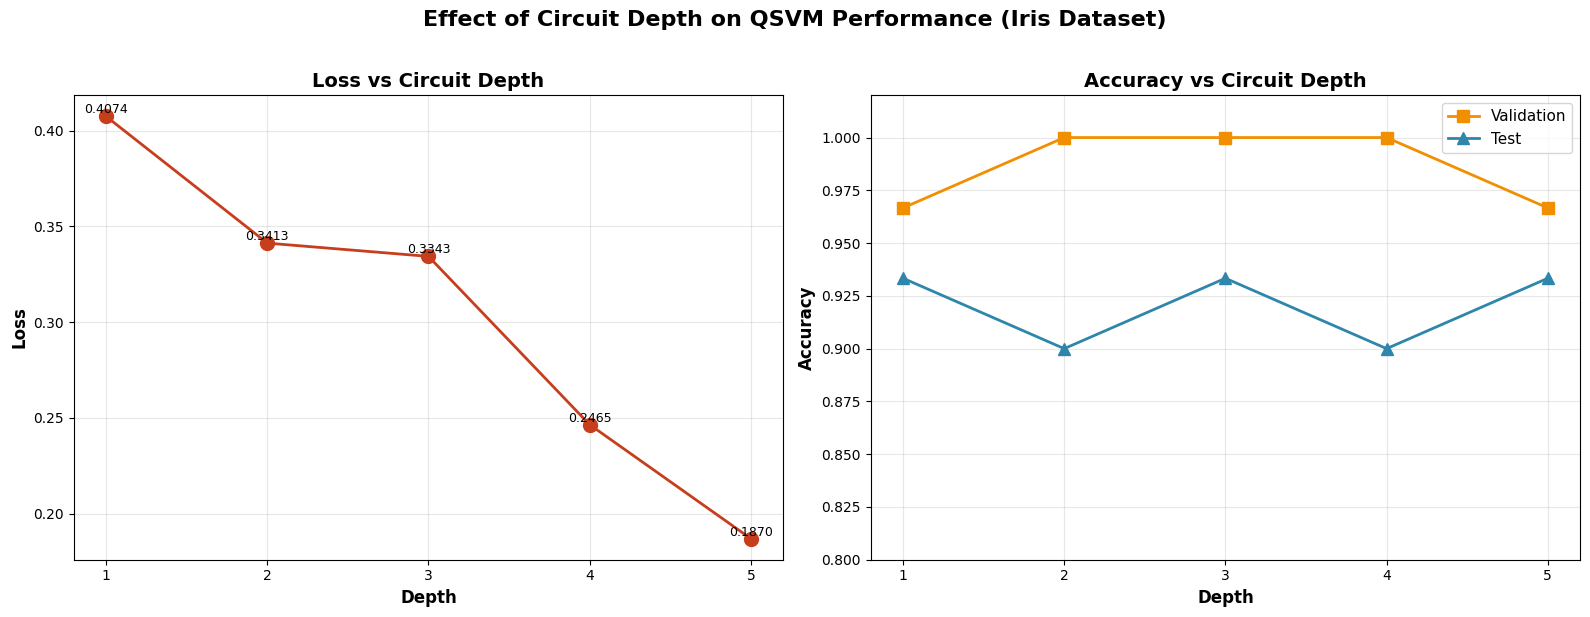

In [36]:
# Combined visualization: Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Loss vs Depth
ax1.plot(depths_list, losses, 'o-', linewidth=2, markersize=10, color='#C73E1D')
ax1.set_xlabel('Depth', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Loss vs Circuit Depth', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(depths_list)

for d, loss in zip(depths_list, losses):
    ax1.text(d, loss, f'{loss:.4f}', ha='center', va='bottom', fontsize=9)

# Right plot: Accuracy vs Depth
ax2.plot(depths_list, val_accs, 's-', linewidth=2, markersize=8, label='Validation', color='#F18F01')
ax2.plot(depths_list, test_accs, '^-', linewidth=2, markersize=8, label='Test', color='#2E86AB')
ax2.set_xlabel('Depth', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy vs Circuit Depth', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(depths_list)
ax2.set_ylim([0.8, 1.02])

plt.suptitle('Effect of Circuit Depth on QSVM Performance (Iris Dataset)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

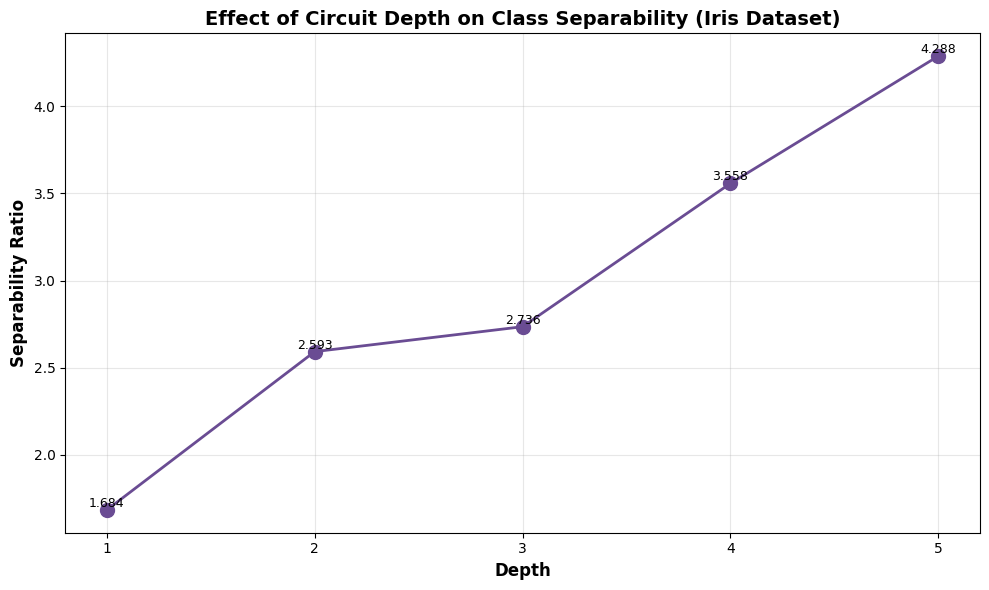


Separability Summary:
Depth 1: 1.684103
Depth 2: 2.592628
Depth 3: 2.735664
Depth 4: 3.557964
Depth 5: 4.288283


In [38]:
# Visualize Separability Ratio vs Depth
sep_ratios = [accuracy_results[d]['sep_ratio'] for d in depths_list]

plt.figure(figsize=(10, 6))
plt.plot(depths_list, sep_ratios, 'o-', linewidth=2, markersize=10, color='#6A4C93')
plt.xlabel('Depth', fontsize=12, fontweight='bold')
plt.ylabel('Separability Ratio', fontsize=12, fontweight='bold')
plt.title('Effect of Circuit Depth on Class Separability (Iris Dataset)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(depths_list)

# Add value labels on each point
for d, sep in zip(depths_list, sep_ratios):
    plt.text(d, sep, f'{sep:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nSeparability Summary:")
for d in depths_list:
    print(f"Depth {d}: {accuracy_results[d]['sep_ratio']:.6f}")

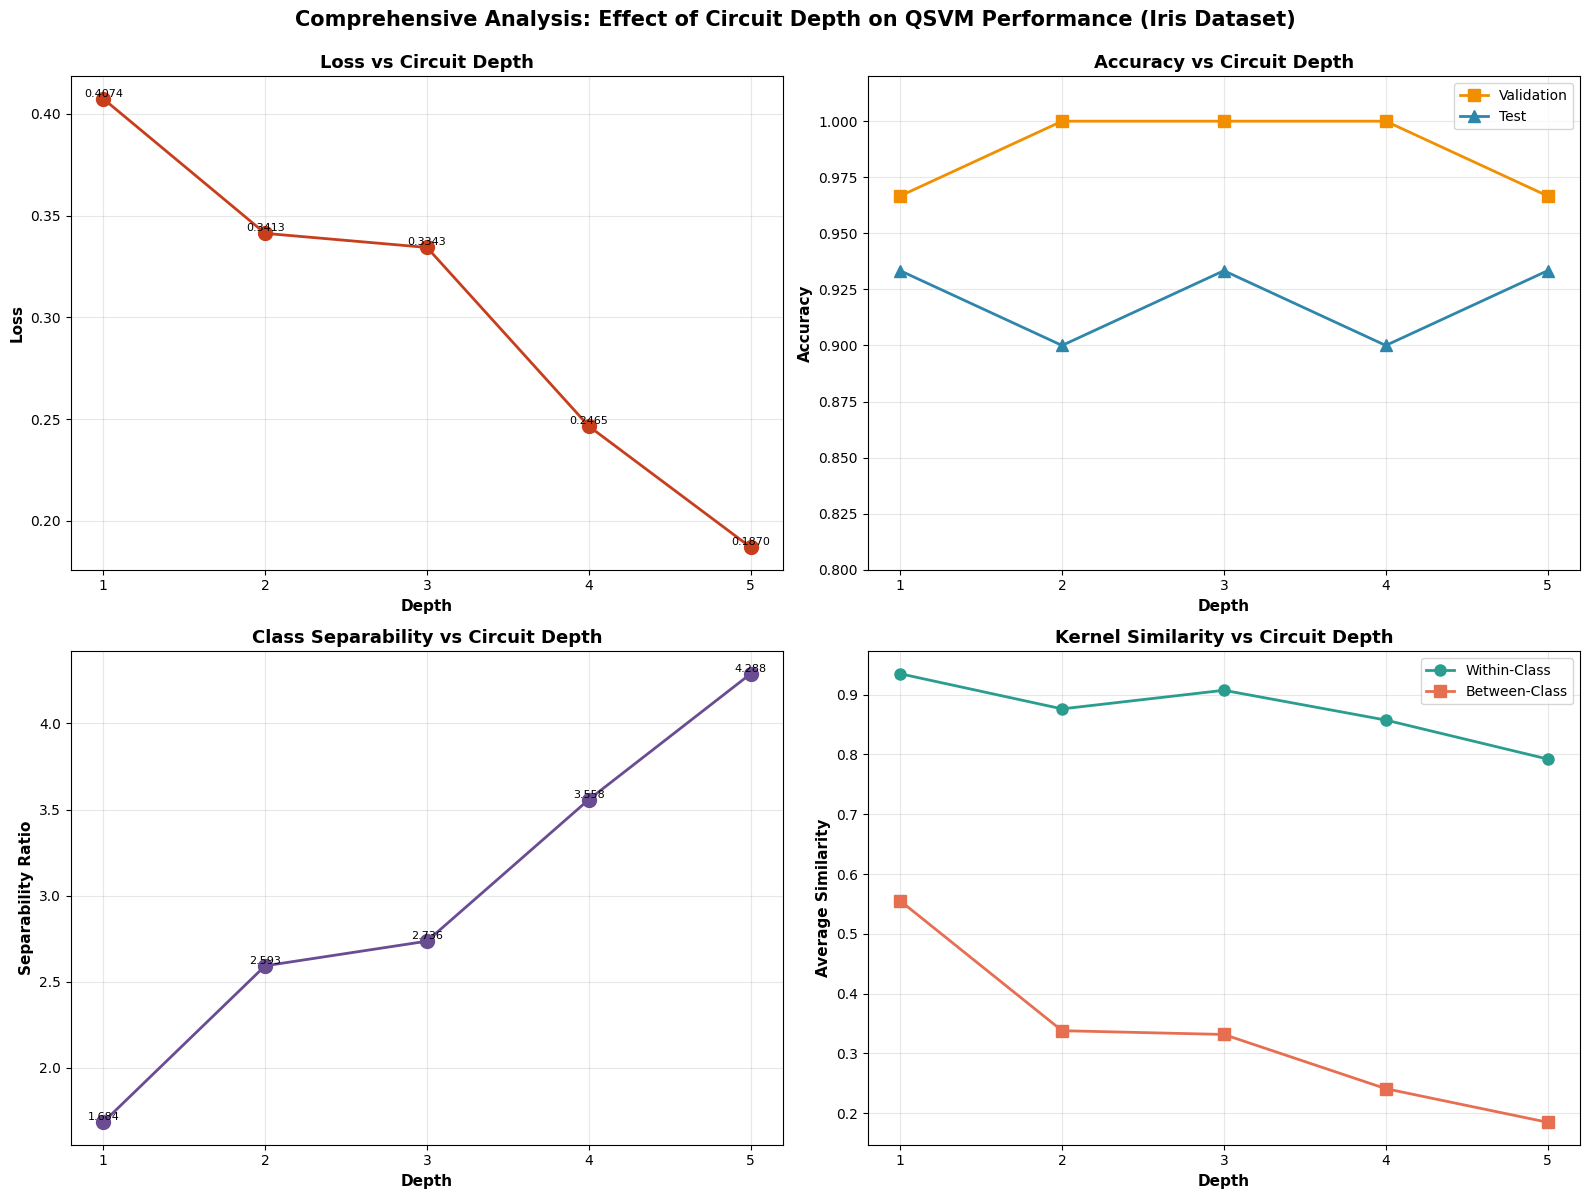

In [39]:
# Comprehensive visualization: Loss, Accuracy, and Separability
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Loss vs Depth
ax1.plot(depths_list, losses, 'o-', linewidth=2, markersize=10, color='#C73E1D')
ax1.set_xlabel('Depth', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax1.set_title('Loss vs Circuit Depth', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(depths_list)
for d, loss in zip(depths_list, losses):
    ax1.text(d, loss, f'{loss:.4f}', ha='center', va='bottom', fontsize=8)

# Plot 2: Accuracy vs Depth
ax2.plot(depths_list, val_accs, 's-', linewidth=2, markersize=8, label='Validation', color='#F18F01')
ax2.plot(depths_list, test_accs, '^-', linewidth=2, markersize=8, label='Test', color='#2E86AB')
ax2.set_xlabel('Depth', fontsize=11, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('Accuracy vs Circuit Depth', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(depths_list)
ax2.set_ylim([0.8, 1.02])

# Plot 3: Separability Ratio vs Depth
ax3.plot(depths_list, sep_ratios, 'o-', linewidth=2, markersize=10, color='#6A4C93')
ax3.set_xlabel('Depth', fontsize=11, fontweight='bold')
ax3.set_ylabel('Separability Ratio', fontsize=11, fontweight='bold')
ax3.set_title('Class Separability vs Circuit Depth', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(depths_list)
for d, sep in zip(depths_list, sep_ratios):
    ax3.text(d, sep, f'{sep:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 4: Within vs Between Class Similarity
avg_withins = [accuracy_results[d]['avg_within'] for d in depths_list]
avg_betweens = [accuracy_results[d]['avg_between'] for d in depths_list]
ax4.plot(depths_list, avg_withins, 'o-', linewidth=2, markersize=8, label='Within-Class', color='#2A9D8F')
ax4.plot(depths_list, avg_betweens, 's-', linewidth=2, markersize=8, label='Between-Class', color='#E76F51')
ax4.set_xlabel('Depth', fontsize=11, fontweight='bold')
ax4.set_ylabel('Average Similarity', fontsize=11, fontweight='bold')
ax4.set_title('Kernel Similarity vs Circuit Depth', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_xticks(depths_list)

plt.suptitle('Comprehensive Analysis: Effect of Circuit Depth on QSVM Performance (Iris Dataset)', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [43]:
# Statistical Summary Table
import pandas as pd

summary_data = []
for d in depths_list:
    summary_data.append({
        'Depth': d,
        'Final Loss': accuracy_results[d]['loss'],
        'Val Acc': accuracy_results[d]['val_acc'],
        'Test Acc': accuracy_results[d]['test_acc'],
        'Sep Ratio': accuracy_results[d]['sep_ratio'],
        'Avg Within': accuracy_results[d]['avg_within'],
        'Avg Between': accuracy_results[d]['avg_between']
    })

df_summary = pd.DataFrame(summary_data)
print("=" * 120)
print("DEPTH ANALYSIS SUMMARY - IRIS DATASET (Best Model per Depth)")
print("=" * 120)
print(df_summary.to_string(index=False))
print("=" * 120)

# Find optimal depth
best_depth_by_loss = min(depths_list, key=lambda d: accuracy_results[d]['loss'])
best_depth_by_test = max(depths_list, key=lambda d: accuracy_results[d]['test_acc'])
best_depth_by_sep = max(depths_list, key=lambda d: accuracy_results[d]['sep_ratio'])

print(f"\n🏆 Best Depth by Loss: {best_depth_by_loss} (Loss = {accuracy_results[best_depth_by_loss]['loss']:.6f})")
print(f"🏆 Best Depth by Test Accuracy: {best_depth_by_test} (Accuracy = {accuracy_results[best_depth_by_test]['test_acc']:.4f})")
print(f"🏆 Best Depth by Separability: {best_depth_by_sep} (Sep Ratio = {accuracy_results[best_depth_by_sep]['sep_ratio']:.4f})")

# Calculate improvements
loss_improvement = ((losses[0] - min(losses)) / losses[0]) * 100
print(f"\n📊 Loss Improvement from Depth 1 to Best: {loss_improvement:.2f}%")

if max(test_accs) > test_accs[0]:
    acc_improvement = ((max(test_accs) - test_accs[0]) / test_accs[0]) * 100
    print(f"📊 Test Accuracy Improvement from Depth 1 to Best: {acc_improvement:.2f}%")

DEPTH ANALYSIS SUMMARY - IRIS DATASET (Best Model per Depth)
 Depth  Final Loss  Val Acc  Test Acc  Sep Ratio  Avg Within  Avg Between
     1    0.407403 0.966667  0.933333   1.684103    0.934917     0.555142
     2    0.341275 1.000000  0.900000   2.592628    0.876182     0.337951
     3    0.334347 1.000000  0.933333   2.735664    0.907284     0.331650
     4    0.246511 1.000000  0.900000   3.557964    0.857483     0.241004
     5    0.187020 0.966667  0.933333   4.288283    0.792307     0.184761

🏆 Best Depth by Loss: 5 (Loss = 0.187020)
🏆 Best Depth by Test Accuracy: 1 (Accuracy = 0.9333)
🏆 Best Depth by Separability: 5 (Sep Ratio = 4.2883)

📊 Loss Improvement from Depth 1 to Best: 54.09%


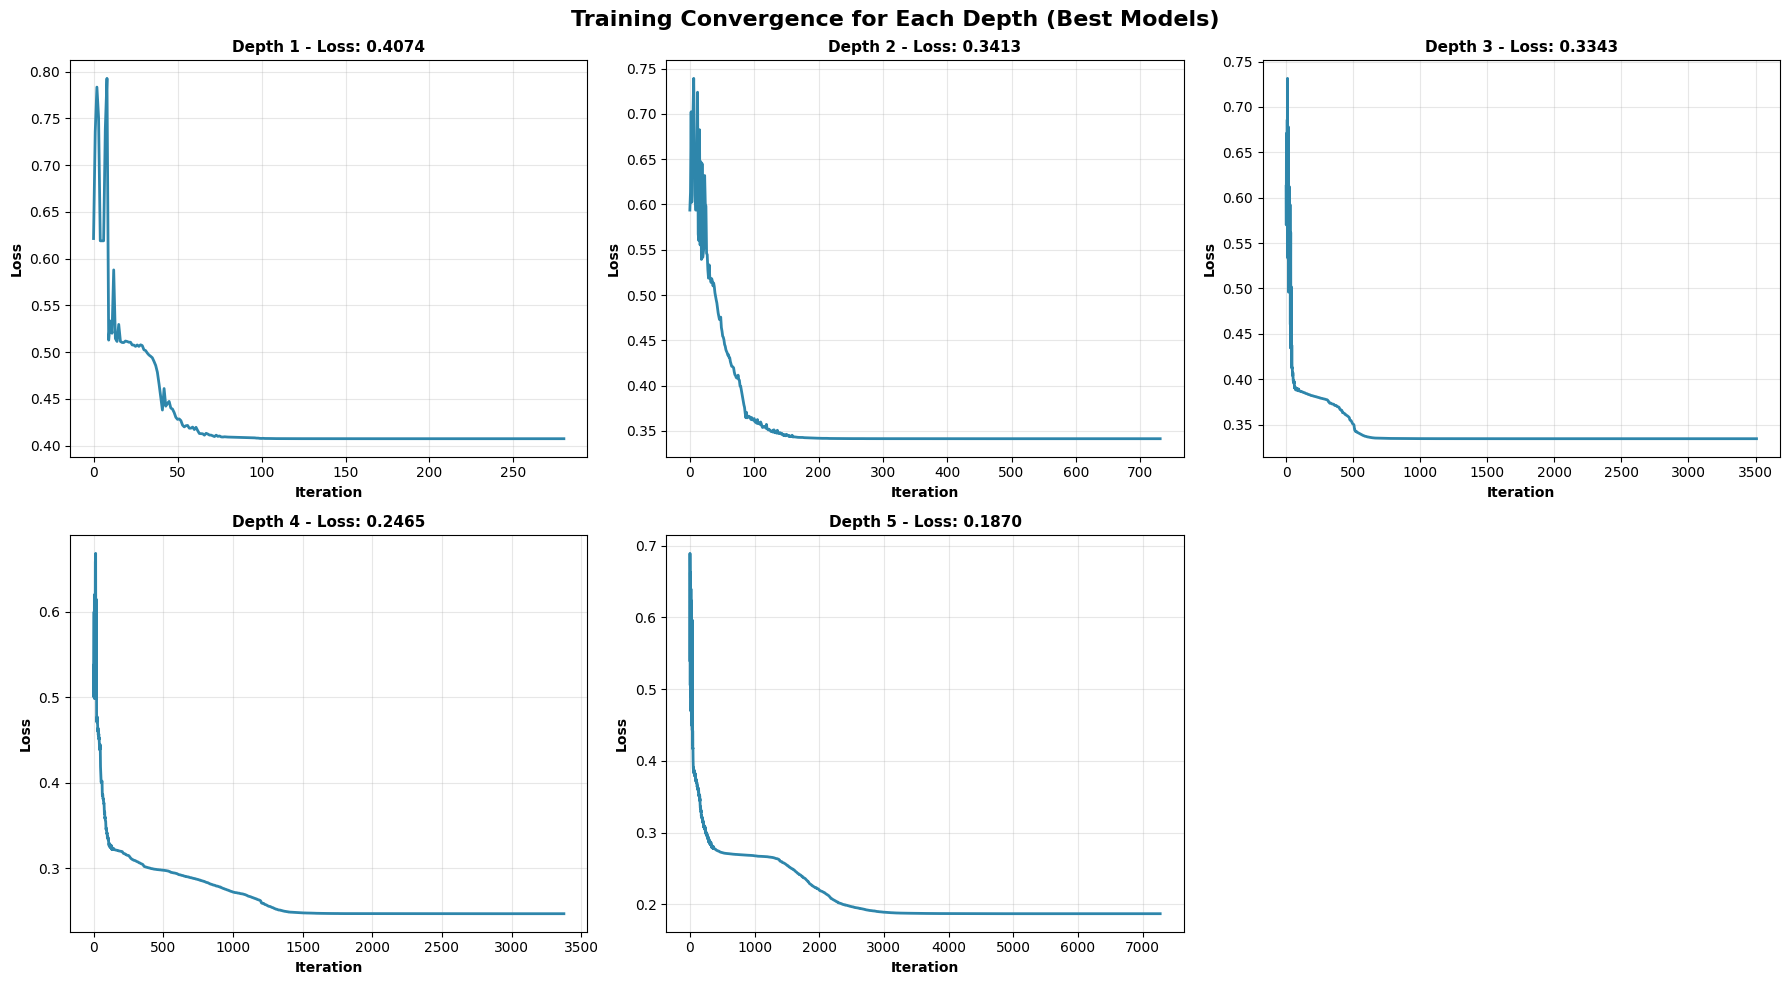

In [45]:
# Visualize training convergence for best models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, depth in enumerate(depths_list):
    model_info = best_models[depth]
    tqfm = model_info['tqfm']
    loss_history = tqfm.loss_history
    
    axes[idx].plot(loss_history, linewidth=2, color='#2E86AB')
    axes[idx].set_xlabel('Iteration', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Loss', fontsize=10, fontweight='bold')
    axes[idx].set_title(f'Depth {depth} - Loss: {loss_history[-1]:.4f}', 
                       fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
# Hide the 6th subplot if only 5 depths
if len(depths_list) == 5:
    axes[5].axis('off')

plt.suptitle('Training Convergence for Each Depth (Best Models)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

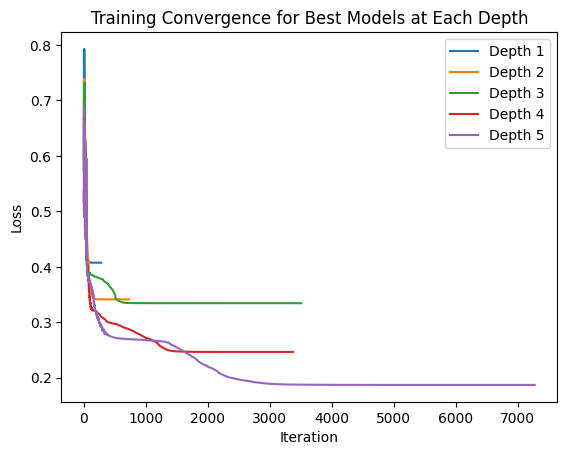

In [58]:
# Visualize training convergence for best models in a plot
# (This cell is optional and can be omitted if already visualized above)

for depth in depths_list:
	model_info = best_models[depth]
	tqfm = model_info['tqfm']
	
	plt.plot(tqfm.loss_history, label=f'Depth {depth}')
plt.title('Training Convergence for Best Models at Each Depth')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.show()